# Exploring the FDA Adverse Event Reporting System

The U.S. Food and Drug Administration (FDA) regulates over-the-counter and prescription drugs in the United States, including biological therapeutics and generic drugs. An 'adverse event' associcated with the use of these drugs is any undesirable effect resulting from its useage such as unwanted side effects or inefficacy. Adverse event reports made to the FDA are compiled into a publically accessible database - the FDA Adverse Event Reporting System (FAERS).  The database contains adverse event reports, medication error reports and product quality complaints.
 
For this task, I have performed an exploratory analysis of the database as a whole in order to understand its contents and structure. I have then focussed on a sample section of the database, specifically pediatric patients that fall into the category as 'child' in the database (i.e. excluding babies and teenagers). I have explored trends in these data using a range of visualisations and different statistical techniques. I have concluded this work with an illustrative logistic regression model that, with further work, could be developed to predict severity of pediatric patient adverse responses given data about the patient and drug. 

I have presented my work in two Jupyter notebooks in order to allow the reader to view the code, data and visulatisations. The first is an exploration of the FDA Adverse Event Reporting System and the second is a study into a small sample of pediatric patients.

In [25]:
# import standard modules necessary for data processing and visualisation
# set style for plotting
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from matplotlib.ticker import (FormatStrFormatter)
import numpy as np
import math
import json
plt.style.use('seaborn')
plt.rcParams['figure.figsize'] = (10.0, 6.0)

# import my modules
import collect_data 

# define the base of the URL used to access the database
# search terms will be appended to this to obtain specific recordsets
url_base = "https://api.fda.gov/drug/event.json?search=receivedate:[20030101+TO+20200528]"

### The evolution of reporting to the FAERS

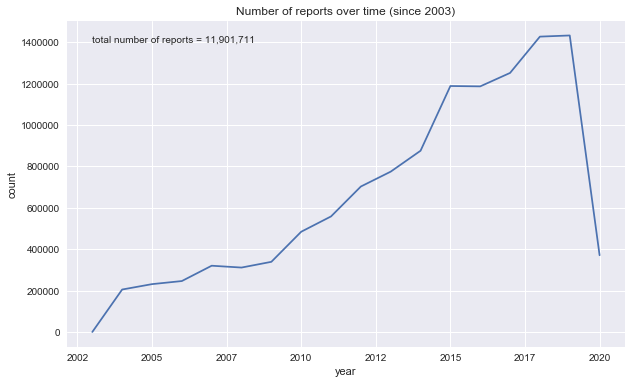

In [24]:
# collect record count by date
data = collect_data.get_data_from_url(url_base, count='receivedate')

# format data in datetime format and isolate year
pd.to_datetime(data['time'], yearfirst = True)
data['year']=pd.DatetimeIndex(data['time']).year

# plot number of reports over time
ax = data.groupby('year').sum().reset_index().plot(x='year', y='count')
ax.xaxis.set_major_formatter(FormatStrFormatter('%d'))
ax.set_ylabel('count')
ax.get_legend().remove()
ax.set_title(f"Number of reports over time (since {data['year'].min()})")
total_str = f"total number of reports = {data['count'].sum():,}"
ax.text(2003, 1400000, total_str);

This is a large recordset with nearly 12 million adverse reports since 2003. Handling the entire body of data at once is not practical for this task and will require repeated queries exploring frequencies or detailed analysis of a subset.

### Where are adverse effect reports originating?

The total number of countries in the database is 235 


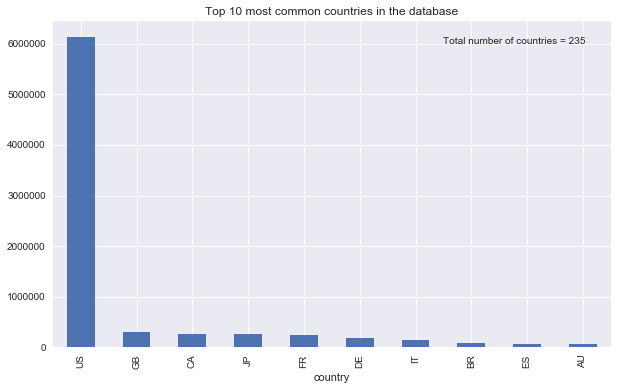

In [19]:
# collect record count by country 
countries = collect_data.collect_country_data(url_base)

# plot frequency with which different countries appear
ax = countries.head(10).plot.bar(x='country',
                            y='count',
                            title = 'Top 10 most common countries in the database')
ax.text(6.5, 6000000, f"Total number of countries = {countries['count'].count()}");
ax.get_legend().remove();

The database is clearly dominated by reports of adverse events that took place in the US. However, this plot also highlights a problem with the database: there are only 197 countries in the world yet there are 235 unique entries for the country of ocurrence in the datbase. Any further detailed analysis of countries should first examine the data for duplicate values, typing errors etc.

### Which adverse effects are most frequently reported?

The top 50 adverse reports make up 88.7% of the total.


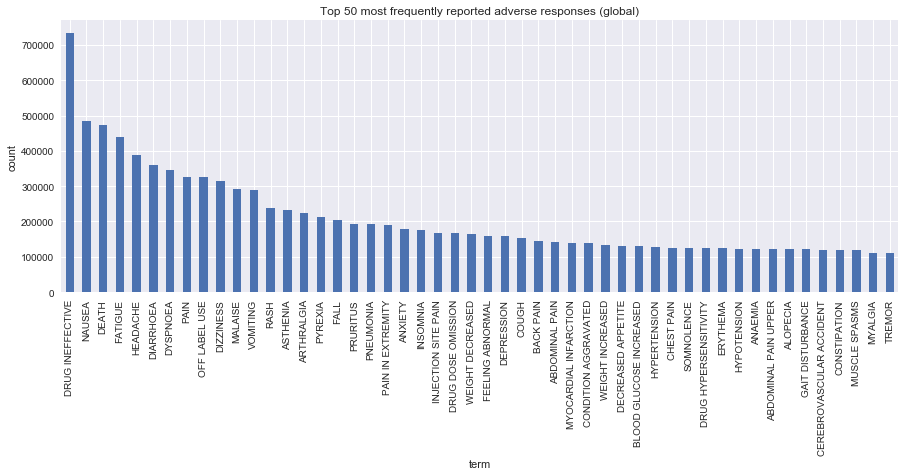

In [4]:
# explore the nature of the adverse effects
# collect top 50 most frequent adverse effects
adverse_effects = collect_data.get_data_from_url(url_base, 
                                                 limit=50, 
                                                 count="patient.reaction.reactionmeddrapt.exact")

# plot adverse effects
ax = adverse_effects.plot.bar(x='term', y='count', figsize=(15, 5))
ax.set_ylabel('count')
ax.get_legend().remove()
print(f"The top 50 adverse reports make up {100*adverse_effects['count'].sum()/total_reports:.1f}% of the total.")
plt.title("Top 50 most frequently reported adverse responses (global)");

The most prevalent adverse effect reported is 'drug ineffective' which is significantly higher than the next most frequently occuring adverse effect. Perhaps surprising, 'death' appears as the third most frequently reported adverse effect. 

### What is the age distribution of patients in adverse effect reports?

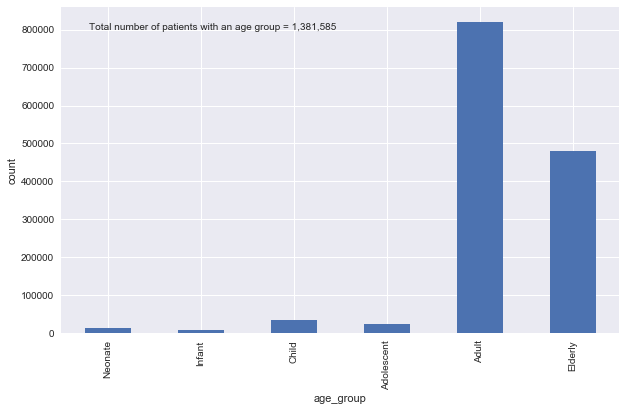

In [39]:
# collect recordset by patient age group 
data = collect_data.get_data_from_url(url_base, 
                                      count="patient.patientagegroup")
num_patient_age_reports = data['count'].sum()

# plot pie 
data.sort_values('term',inplace=True)
age_group_map = {1 : 'Neonate',
                 2 : 'Infant',
                 3 : 'Child',
                 4 : 'Adolescent',
                 5 : 'Adult',
                 6 : 'Elderly'}
data['age_group'] = data['term'].map(age_group_map)
ax = data.plot.bar(x='age_group',y='count')
ax.get_legend().remove()
ax.set_ylabel('count')
ax.text(-0.2, 800000, f"Total number of patients with an age group = {num_patient_age_reports:,}");
plt.show()

# check total number of reports with no patient age + no reports with patient age equals total number report
url = collect_data.create_search_url(url_base, 
                                     search_key='_missing_', 
                                     search_term='patient.patientagegroup', 
                                     count="receivedate")
test_data = collect_data.get_data_from_url(url)
assert num_patient_age_reports + test_data['count'].sum() == total_reports, "Inconsistent queries."

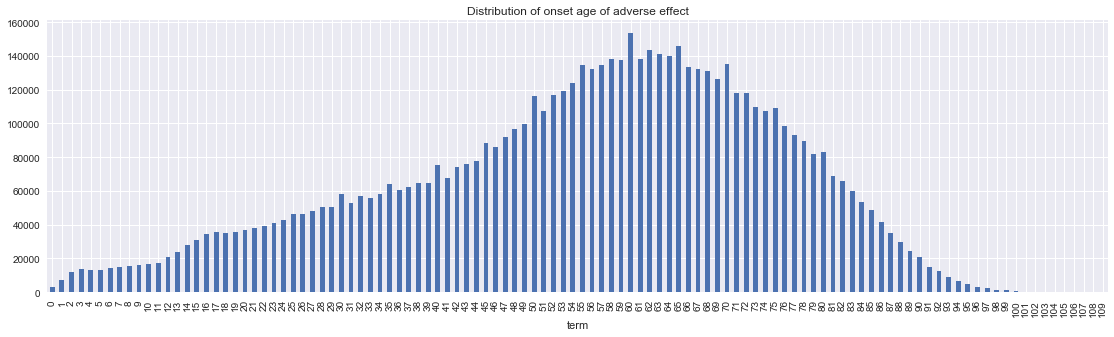

In [61]:
# search for all patient onsetages sepcified in years (801)
# comprises 97% of all records with specified ages 
data = collect_data.get_data_from_url(url_base, 
                                      search_key='patient.patientonsetageunit', 
                                      search_term='801', 
                                      count="patient.patientonsetage", 
                                      sort="patient.patientonsetage", 
                                      limit=1000)
data.sort_values('term', inplace=True)

# drop reports with unrealistic ages from dataframe
data = data[data['term']<110]

# plot distribution of ages
ax = data.plot.bar(x='term',y='count',figsize=(19,5));
ax.set_title('Distribution of onset age of adverse effect');
ax.get_legend().remove()

## Severity of adverse effects

We can consider the severity of adverse effects. At the simplest level, an adverse effect is classified as either serious (where the adverse event resulted in death, a life threatening condition, hospitalization, disability, congenital anomaly, or other serious condition), or 'not serious' (where the adverse event did not result in any of these). </br>

### How is severity of adverse response affected by drug type?

There are a variety of ways of grouping drug types in the database, but one of the most simple is whether the drug was 'over-the-counter' (OTC) or prescription. Naively, you might expect prescription drugs to be more likely to results in serious adverse responses than OTC drugs.

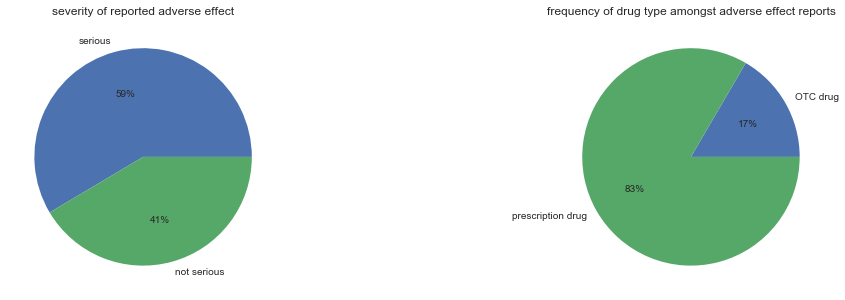

In [69]:
# collect data grouped by severity and product type
data = collect_data.get_data_from_url(url_base, search_key='serious', search_term='1', count='patient.drug.openfda.product_type.exact')
data['severity']=1
data2 = collect_data.get_data_from_url(url_base, search_key='serious', search_term='2', count='patient.drug.openfda.product_type.exact')
data2['severity']=2
data = data.append(data2)
data.rename(columns={'term' : 'drug type'}, inplace=True)

# construct pivot table
cont_table = data.pivot_table(values='count', index=data["drug type"], columns=['severity'],aggfunc='sum')
cont_table = 100*cont_table/data['count'].sum()
cont_table.rename(columns={1:'serious',2:'not serious'}, inplace=True)

# plot pie charts of global frequency of severity and drug type
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(18,5))
ax1 = cont_table.sum().plot.pie(autopct='%1.0f%%',ax=ax1);
ax1.set_ylabel('');
ax1.set_title('severity of reported adverse effect')
ax2 = cont_table.sum(axis=1).plot.pie(autopct='%1.0f%%',ax=ax2, labels=['OTC drug','prescription drug'])
ax2.set_title('frequency of drug type amongst adverse effect reports')
ax2.set_ylabel('');

It is clear that the majority of reports in the database resulted in serious adverse effects, perhaps beacuse clinicians and patients are less inclined to go to the effort of submitting reports for less severe cases. We can also see that the significant majority of adverse reports are due to prescription drugs as opposed to over-the-counter (OTC) medications. 

In [63]:
cont_table

severity,serious,not serious
drug type,,
HUMAN OTC DRUG,9.752508,6.841004
HUMAN PRESCRIPTION DRUG,48.784197,34.622291


The values in the above contingency table indicate the percentage of reports that fall into each category. Somewhat surprisingly, the ratio of serious adverse effects to not serious adverse effects is simlar for both OTC and prescription medication as we can see more clearly below.

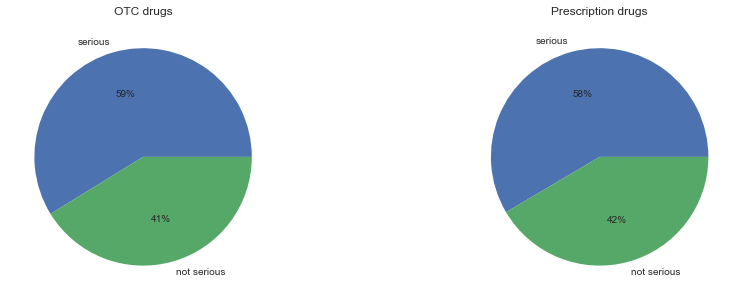

In [70]:
# construct pie charts to show relative frequency of seriousness
# for both OTC and prescription drug
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(15,5))
ax1 = cont_table.loc['HUMAN OTC DRUG',:].plot.pie(autopct='%1.0f%%', ax=ax1);
ax1.set_ylabel('');
ax1.set_title('OTC drugs');
ax2 = cont_table.loc['HUMAN PRESCRIPTION DRUG',:].plot.pie(autopct='%1.0f%%', ax=ax2);
ax2.set_ylabel('');
ax2.set_title('Prescription drugs');

### How is severity of response influenced by drug delivery route?

We can perform a similar analysis for other properties of the delivered medicine. For example, let's consider a more complex contingency table with different levels of severity considered against different drug indications.

In [93]:
# collect all serious outcome data
serious_outcomes = ['congenitalanomali','death','hospitalization','disabling','lifethreatening','other']
for i, outcome in enumerate(serious_outcomes):
    search_str = 'seriousness' + outcome
    sub_data = collect_data.get_data_from_url(url_base, search_key=search_str, search_term='1', count='patient.drug.openfda.route.exact', limit=1000)
    sub_data.rename(columns={'count' : outcome}, inplace=True)
    if i == 0:
        data = sub_data
    else:
        data = pd.merge(data, sub_data, how="outer", on="term")
        
# replace missing values with zeros
data = data.fillna(0)

# sort data and calculate a total column
data['total'] = data.sum(axis=1)
total = data['total'].sum()
data.sort_values(by=['total'], inplace=True, ascending=False)
data = data.set_index('term')
#assert 0.999  <data['fraction'].sum() <1.001, 'Fraction calculation incorrect.'

# preview data
data.head(10).style.format("{:,.0f}")


,congenitalanomali,death,hospitalization,disabling,lifethreatening,other,total
term,,,,,,,
ORAL,"38,678","785,472","1,979,893","183,962","254,748","2,735,117","5,977,870"
INTRAVENOUS,"14,673","457,061","1,109,459","94,757","157,618","1,469,330","3,302,898"
SUBCUTANEOUS,"6,771","202,192","566,898","38,320","61,183","828,736","1,704,100"
INTRAMUSCULAR,"8,264","192,790","539,869","51,727","74,313","657,113","1,524,076"
TOPICAL,"2,705","95,439","276,037","24,723","42,218","350,749","791,871"
RECTAL,"1,626","82,430","241,558","19,234","31,937","237,130","613,915"
OPHTHALMIC,"1,156","55,942","158,438","15,727","25,589","207,612","464,464"
RESPIRATORY (INHALATION),944,"40,790","146,974","10,009","16,373","168,643","383,733"
INTRATHECAL,700,"35,619","111,652","8,862","15,050","173,724","345,607"


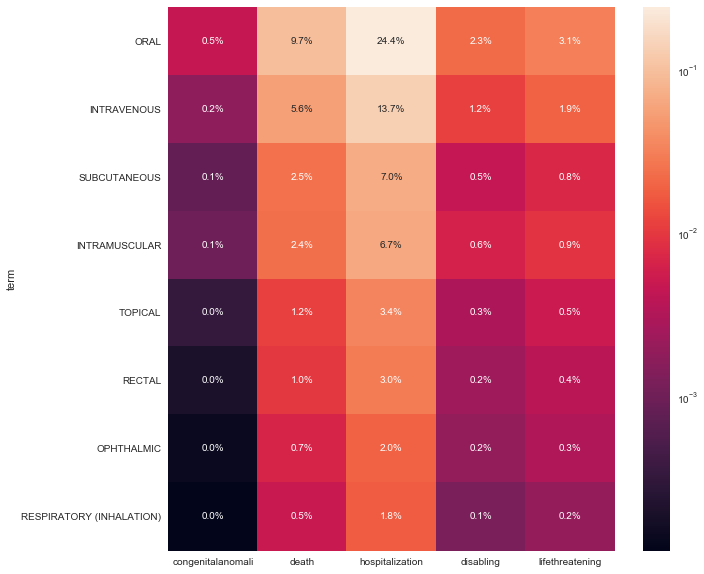

In [91]:
# create a heatmap for seriousness type against drug delivery method
# consider only the main delivery routes (i.e. those indicated in >1% of reports)
sub_data = data.loc[:,'congenitalanomali':'lifethreatening'].head(8)
total_count = (sub_data.sum().sum())
sub_data = sub_data.divide(total_count)
fig = plt.figure(figsize=(10,10));
ax = sns.heatmap(sub_data,
                 norm=LogNorm(vmin=sub_data.min().min(), vmax=sub_data.max().max()),
                 annot=True,
                fmt='.1%');
assert 0.999 <= sub_data.sum().sum() <= 1.001, "Percentage calculation incorrect."

We can see from the heatmap that oral and intravenous delivery routes are the most prevalent with hospitalisation as a result of oral medication being the most significant grouping by a significant margin. 

### What types of illnesses result in serious adverse reports?

We might expect more serious illnesses or indications to result in more serious side effects due to the necessity for more powerful or more risky medication. Alternatively, conditions which require long-term drug such as diabetes might be more prevalent. We examine the types of illnesses that appear in the database.

In [94]:
# collect drug indication data grouped on seriousness outcome
serious_outcomes = ['congenitalanomali','death','hospitalization','disabling','lifethreatening','other']
for i, outcome in enumerate(serious_outcomes):
    search_str = 'seriousness' + outcome
    sub_data = collect_data.get_data_from_url(url_base, search_key=search_str, search_term='1', count='patient.drug.drugindication.exact', limit=1000)
    sub_data.rename(columns={'count' : outcome}, inplace=True)
    if i==0:
        data = sub_data
    else:
        data = pd.merge(data, sub_data, how="outer", on="term")
data = data.fillna(0)
data.set_index('term', inplace=True)

# ignore reports where the indication was not known
data = data.drop('PRODUCT USED FOR UNKNOWN INDICATION')
data = data.drop('DRUG USE FOR UNKNOWN INDICATION')

# calculate totals
data['total']=data.sum(axis=1)
data.sort_values(by=['total'], inplace=True, ascending=False)

# preview data
data.head(10).style.format("{:,.0f}")

,congenitalanomali,death,hospitalization,disabling,lifethreatening,other,total,fraction
term,,,,,,,,
HYPERTENSION,974,"26,915","158,320","13,533","24,403","161,383","385,528",0
RHEUMATOID ARTHRITIS,395,"25,294","120,202","8,307","10,448","205,240","369,886",0
DIABETES MELLITUS,171,"21,715","99,034","5,426","8,993","109,914","245,253",0
PAIN,570,"39,811","79,889","9,710","9,966","98,282","238,228",0
MULTIPLE SCLEROSIS,298,"14,696","114,819","3,857","3,136","94,661","231,467",0
DEPRESSION,"4,586","12,168","67,415","10,088","12,227","96,649","203,133",0
PLASMA CELL MYELOMA,36,"30,132","71,559","3,336","5,644","85,907","196,614",0
ATRIAL FIBRILLATION,25,"21,243","91,661","4,305","12,744","49,429","179,407",0
PROPHYLAXIS,337,"20,159","62,126","4,030","10,949","61,057","158,658",0


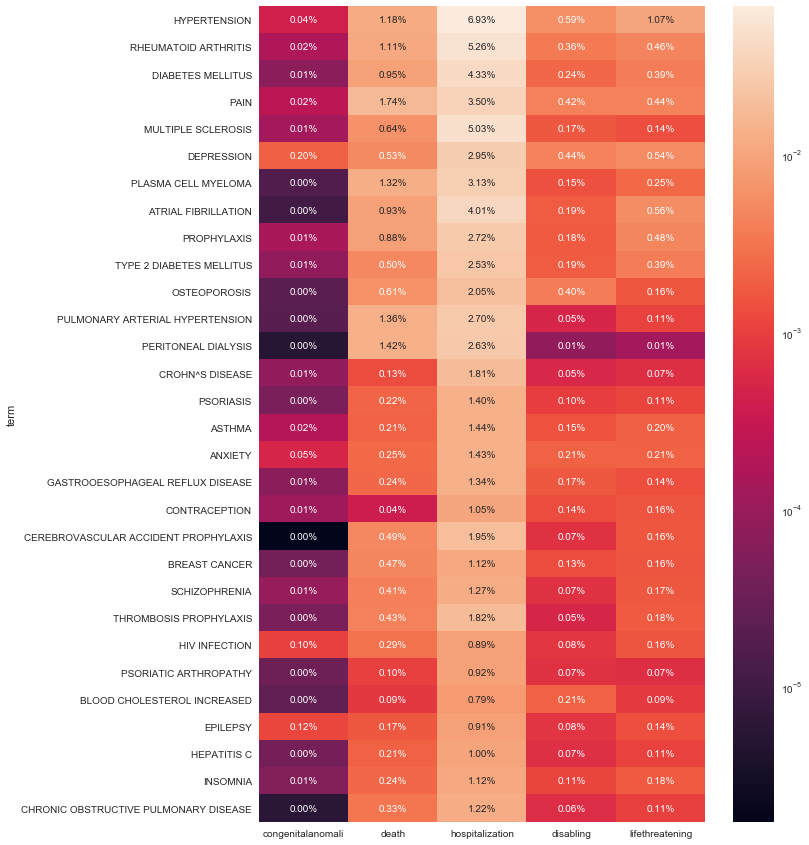

In [97]:
#construct a heatmap to better illustrate contingency table
sub_data = data.loc[:,'congenitalanomali':'lifethreatening'].head(30)
total_count = (sub_data.sum().sum())
sub_data = sub_data.divide(total_count)
fig = plt.figure(figsize=(10,15));
ax = sns.heatmap(sub_data,
                 norm=LogNorm(vmin=sub_data.min().min(), vmax=sub_data.max().max()),
                 annot=True,fmt='.2%');

Whilst the majority of entries in this contingency table are very small, certain hotspots can be seen. We clearly see that the top few indications, including hypertension rheumatoid arthritis and diabetes appear significantly more frequently than many other diseases. It would be of use to compare the rate of cocurrence fo these indications with data for teh general population to see if they are over or under represented here.

We can also see that there are certain spots in the heatmap that move away from the general trends. For example, the death rate is less than might be expected for contraception. Similarly, peritoneal dialysis is less disabling and less life threatening than other indications. 

</br>

Please see the [next notebook](https://github.com/ambevan/OpenFDA_Case_Study/blob/master/Severity%20of%20adverse%20reactions%20in%20children.ipynb) for a more quantitative analysis of a sample of the database.